# [Predictive Clinical Neuroscience Toolkit](https://github.com/amarquand/PCNtoolkit) 
# Hierarchical Bayesian Regression Normative Modelling and Transfer onto unseen site.

This notebook will go through basic data preparation (training and testing set, [see Saige's tutorial](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/ROI_blr_cortthick/NormativeModelTutorial.ipynb) on Normative Modelling for more detail), the actual training of the models, and will finally describe how to transfer the trained models onto unseen sites. 

### Created by [Saige Rutherford](https://twitter.com/being_saige) and Andre Marquand
### adapted/edited by Pierre Berthet

<div>
<img src="../../data/NormModelSetup.png" width="500"/>
</div>

## Step 0: Install necessary libraries & grab data files

In [ ]:
! git clone https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo.git

In [1]:
import os

In [ ]:
# set this path to the git cloned PCNtoolkit-demo repository --> Uncomment whichever line you need for either running on your own computer or on Google Colab.
#os.chdir('/Users/saigerutherford/repos/PCNtoolkit-demo/') # if running on your own computer, use this line (but obvi change the path)
#os.chdir('PCNtoolkit-demo/') # if running on Google Colab, use this line

In [ ]:
! pip install -r requirements.txt

For this tutorial we will use data from the [Functional Connectom Project FCON1000](http://fcon_1000.projects.nitrc.org/) to create a multi-site dataset. 

The dataset contains some cortical measures (eg thickness), processed by Freesurfer 6.0, and some covariates (eg age, site, gender).

In [12]:
import pandas as pd
import pcntoolkit as ptk
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

#### Overview
Here we get the FCON dataset, remove the ICBM site for later transfer, assign some site id to the different scanner sites and print an overview of the left hemisphere mean raw cortical thickness as a function of age, color coded by the various sites:


site AnnArbor_a 24
site AnnArbor_b 32
site Atlanta 28
site Baltimore 23
site Bangor 20
site Beijing_Zang 198
site Berlin_Margulies 26
site Cambridge_Buckner 198
site Cleveland 31
site Leiden_2180 12
site Leiden_2200 19
site Milwaukee_b 46
site Munchen 15
site NewYork_a 83
site NewYork_a_ADHD 25
site Newark 19
site Oulu 102
site Oxford 22
site PaloAlto 17
site Pittsburgh 3
site Queensland 19
site SaintLouis 31


Text(0.5, 0, 'age')

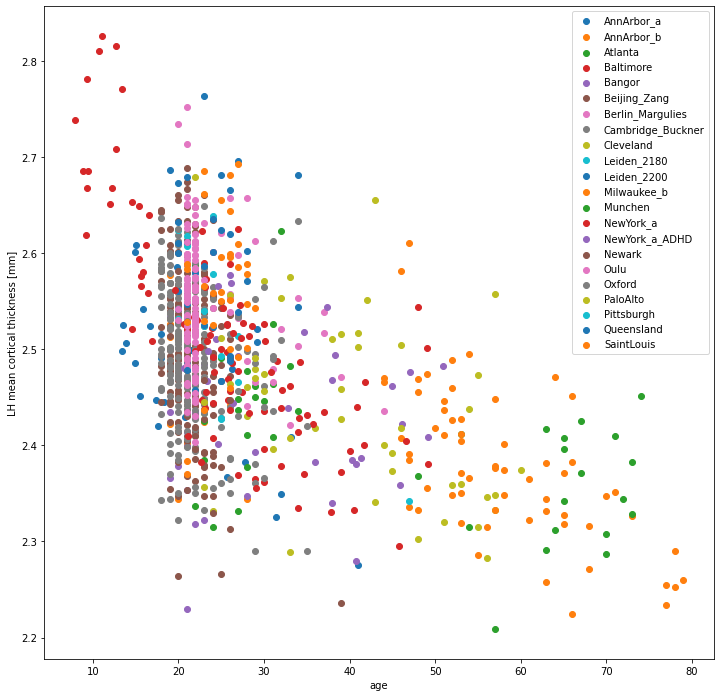

In [13]:
fcon = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000.csv')

icbm = fcon.loc[fcon['site'] == 'ICBM']
icbm['sitenum'] = 0
fcon = fcon.loc[fcon['site'] != 'ICBM']

sites = fcon['site'].unique()
fcon['sitenum'] = 0

f, ax = plt.subplots(figsize=(12, 12))

for i,s in enumerate(sites):
    idx = fcon['site'] == s
    fcon['sitenum'].loc[idx] = i
    
    print('site',s, sum(idx))
    ax.scatter(fcon['age'].loc[idx], fcon['lh_MeanThickness_thickness'].loc[idx])
    
ax.legend(sites)
ax.set_ylabel('LH mean cortical thickness [mm]')
ax.set_xlabel('age')


## Step 1: Prepare training and testing sets

Then we randomly split half of the samples (participants) to be either in the training or in the testing samples. We do this for the remaing FCON dataset and for the ICBM data. The transfer function will also require a training and a test sample. 

The numbers of samples per sites used for training and for testing are then displayed.

In [28]:
tr = np.random.uniform(size=fcon.shape[0]) > 0.5
te = ~tr

fcon_tr = fcon.loc[tr]
fcon_te = fcon.loc[te]

tr = np.random.uniform(size=icbm.shape[0]) > 0.5
te = ~tr

icbm_tr = icbm.loc[tr]
icbm_te = icbm.loc[te]

print('sample size check')
for i,s in enumerate(sites):
    idx = fcon_tr['site'] == s
    idxte = fcon_te['site'] == s
    print(i,s, sum(idx), sum(idxte))

# fcon_tr.to_csv('/Users/andmar/data/sairut/data/fcon1000_tr.csv')
# fcon_te.to_csv('/Users/andmar/data/sairut/data/fcon1000_te.csv')
# icbm_tr.to_csv('/Users/andmar/data/sairut/data/fcon1000_icbm_tr.csv')
# icbm_te.to_csv('/Users/andmar/data/sairut/data/fcon1000_icbm_te.csv')

sample size check
0 AnnArbor_a 15 9
1 AnnArbor_b 14 18
2 Atlanta 13 15
3 Baltimore 6 17
4 Bangor 12 8
5 Beijing_Zang 93 105
6 Berlin_Margulies 12 14
7 Cambridge_Buckner 106 92
8 Cleveland 19 12
9 Leiden_2180 6 6
10 Leiden_2200 12 7
11 Milwaukee_b 21 25
12 Munchen 9 6
13 NewYork_a 34 49
14 NewYork_a_ADHD 11 14
15 Newark 11 8
16 Oulu 55 47
17 Oxford 14 8
18 PaloAlto 10 7
19 Pittsburgh 2 1
20 Queensland 10 9
21 SaintLouis 12 19


Otherwise you can just load these pre defined subsets:

In [19]:
fcon_tr = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_tr.csv')
fcon_te = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_te.csv')
icbm_tr = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_icbm_tr.csv')
icbm_te = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000_icbm_te.csv')

# Step 2: Configure HBR inputs: covariates, measures and batch effects

We will here only use the mean cortical thickness for the Right and Left hemisphere: two idps.


In [29]:
idps = ['rh_MeanThickness_thickness','lh_MeanThickness_thickness']

As input to the model, we need covariates (used to describe predictable source of variability (fixed effects), here 'age'), measures (here cortical thickness on two idps), and batch effects (random source of variability, here 'scanner site' and 'sex').

`X` corresponds to the covariate(s) 

`Y` to the measure(s)

`batch_effects` to the random effects

We need these values both for the training (`_train`) and for the testing set (`_test`).

In [33]:
X_train = (fcon_tr['age']/100).to_numpy(dtype=float)
Y_train = fcon_tr[idps].to_numpy(dtype=float)
batch_effects_train = fcon_tr[['sitenum','sex']].to_numpy(dtype=int)
#     
# with open('X_train.pkl', 'wb') as file:
#     pickle.dump(pd.DataFrame(X_train), file)
# with open('Y_train.pkl', 'wb') as file:
#     pickle.dump(pd.DataFrame(Y_train), file) 
# with open('trbefile.pkl', 'wb') as file:
#     pickle.dump(pd.DataFrame(batch_effects_train), file) 


X_test = (fcon_te['age']/100).to_numpy(dtype=float)
Y_test = fcon_te[idps].to_numpy(dtype=float)
batch_effects_test = fcon_te[['sitenum','sex']].to_numpy(dtype=int)
#     
# with open('X_test.pkl', 'wb') as file:
#     pickle.dump(pd.DataFrame(X_test), file)
# with open('Y_test.pkl', 'wb') as file:
#     pickle.dump(pd.DataFrame(Y_test), file) 
# with open('tsbefile.pkl', 'wb') as file:
#     pickle.dump(pd.DataFrame(batch_effects_test), file) 

# Step 3: Files and Folders grooming

In [37]:
processing_dir = "/Users/andmar/data/sairut/hbr/"    # replace with a path to your working directory
processing_dir = "~/"    # replace with a path to your working directory
respfile = processing_dir + 'Y_train.pkl'       # measurements  (eg cortical thickness) of the training samples (columns: the various features/ROIs, rows: observations or subjects)
covfile = processing_dir + 'X_train.pkl'        # covariates (eg age) the training samples (columns: covariates, rows: observations or subjects)

testrespfile_path = processing_dir + 'Y_test.pkl'       # measurements  for the testing samples
testcovfile_path = processing_dir + 'X_test.pkl'        # covariate file for the testing samples

trbefile = processing_dir + 'trbefile.pkl'      # training batch effects file (eg scanner_id, gender)  (columns: the various batch effects, rows: observations or subjects)
tsbefile = processing_dir + 'tsbefile.pkl'      # testing batch effects file

output_path = processing_dir + 'Models/'    #  output path, where the models will be written
log_dir = output_path + 'log/'              #
if not os.path.isdir(output_path):
    os.mkdir(output_path)
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

outputsuffix = '_estimate'      # a string to name the output files, of use only to you, so adapt it for your needs.

# python_path = '/Users/andmar/sfw/anaconda3/envs/py38/bin/python'         # path to your python install, here is mine as an example, within a conda environment.


FileNotFoundError: [Errno 2] No such file or directory: '~/Models/'

# Step 4: Estimating the models

Now we have everything ready ot estimat ethe normative models. The `estimate` function only needs the training and testing sets, each divided in three datasets: covariates, measures and batch effects. We obviously specify `alg=hbr` to use the hierarchical bayesian regression method, well suited for the multi sites datasets. The remaining arguments are basic data management: where the models, logs, and output files will be written and how they will be named.

In [ ]:
ptk.normative.estimate(covfile=covfile, 
                       respfile=respfile,
                       tsbefile=tsbefile, 
                       trbefile=trbefile, 
                       alg='hbr', 
                       log_path=log_dir, 
                       binary=True,
                       output_path=output_path, testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       outputsuffix=outputsuffix, savemodel=True)

Here some analyses can be done, there are also some error metrics that could be of interest. This is covered in step 6 of [Saige's tutorial](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/ROI_blr_cortthick/NormativeModelTutorial.ipynb) on Normative Modelling.

# Step 5: Transfering the models to unseen sites

Similarly to what was done before for the FCON data, we also need to prepare the ICBM specific data, in order to run the transfer function: training and testing set of covariates, measures and batch effects:

In [ ]:
X_adapt = (icbm_tr['age']/100).to_numpy(dtype=float)
Y_adapt = icbm_tr[idps].to_numpy(dtype=float)
batch_effects_adapt = icbm_tr[['sitenum','sex']].to_numpy(dtype=int)
    
with open('X_adaptation.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_adapt), file)
with open('Y_adaptation.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_adapt), file) 
with open('adbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_adapt), file) 

# Test data (new dataset)
X_test_txfr = (icbm_te['age']/100).to_numpy(dtype=float)
Y_test_txfr = icbm_te[idps].to_numpy(dtype=float)
batch_effects_test_txfr = icbm_te[['sitenum','sex']].to_numpy(dtype=int)
    
with open('X_test_txfr.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test_txfr), file)
with open('Y_test_txfr.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test_txfr), file) 
with open('txbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test_txfr), file) 


In [34]:
respfile = processing_dir + 'Y_adaptation.pkl'
covfile = processing_dir + 'X_adaptation.pkl'
testrespfile_path = processing_dir + 'Y_test_txfr.pkl'
testcovfile_path = processing_dir + 'X_test_txfr.pkl'
trbefile = processing_dir + 'adbefile.pkl'
tsbefile = processing_dir + 'txbefile.pkl'

log_dir = processing_dir + 'log_transfer/'
output_path = processing_dir + 'Transfer/'
model_path = processing_dir + 'Models/'  # path to the previously trained models
outputsuffix = '_transfer'  # suffix added to the output files from the transfer function

NameError: name 'processing_dir' is not defined

Here, the difference is that the transfer function needs a model path, which points to the models we just trained, and new site data (training and testing). That is basically the only difference.

In [ ]:
ptk.normative.transfer(covfile=covfile, 
                       respfile=respfile,
                       tsbefile=tsbefile, 
                       trbefile=trbefile, 
                       model_path = model_path,
                       alg='hbr', 
                       log_path=log_dir, 
                       binary=True,
                       output_path=output_path, 
                       testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       outputsuffix=outputsuffix, 
                       savemodel=True)


And that is it, you now have models that benefited from prior knowledge about different scanner sites to learn on unseen sites.

# Step 6: Interpreting model performance

Output evaluation metrics definitions: 
* yhat - predictive mean
* ys2 - predictive variance
* nm - normative model
* Z - deviance scores
* Rho - Pearson correlation between true and predicted responses
* pRho - parametric p-value for this correlation
* RMSE - root mean squared error between true/predicted responses
* SMSE - standardised mean squared error
* EV - explained variance
* MSLL - mean standardized log loss
    * See page 23 in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf